<a href="https://colab.research.google.com/github/DrumilHV/Mit-Labs/blob/main/sem6/DL-LAAB/midsem/MidSem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CNN With State dict

cuda


100%|██████████| 9912422/9912422 [00:00<00:00, 147007779.86it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 105703048.71it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 51245907.13it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5360306.35it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



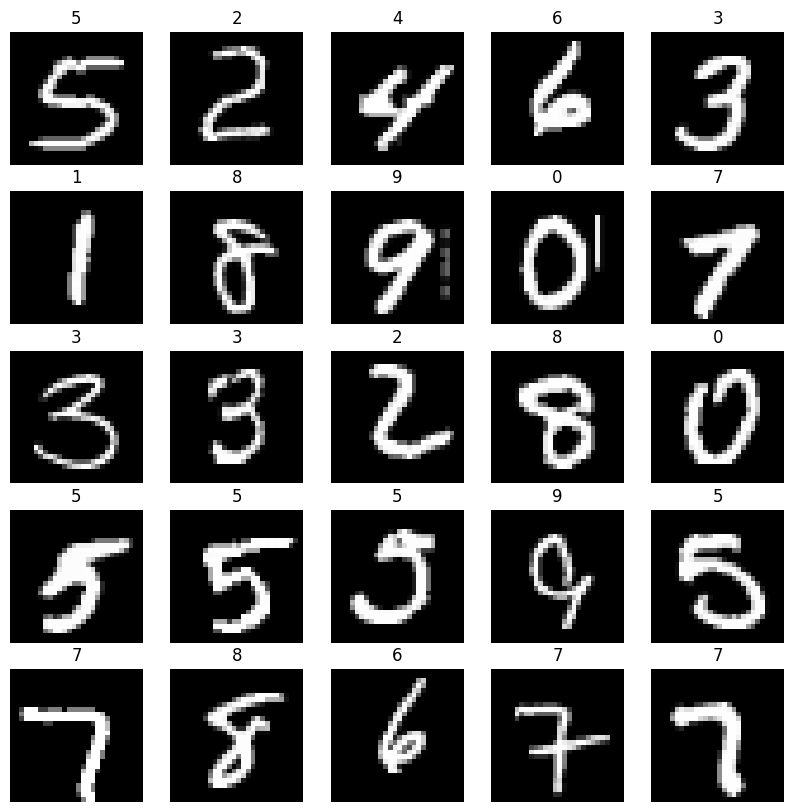

epoch 0 , iter 99 ,loss 2.3067329907417298
epoch 0 , iter 199 ,loss 2.30552734375
epoch 0 , iter 299 ,loss 2.307603018283844
epoch 0 , iter 399 ,loss 2.307556862831116
epoch 0 , iter 499 ,loss 2.304789273738861
epoch 0 , iter 599 ,loss 2.305472810268402
epoch 1 , iter 99 ,loss 2.305320897102356
epoch 1 , iter 199 ,loss 2.3075793051719664
epoch 1 , iter 299 ,loss 2.3053492951393126
epoch 1 , iter 399 ,loss 2.3054052448272704
epoch 1 , iter 499 ,loss 2.307064778804779
epoch 1 , iter 599 ,loss 2.306962766647339
epoch 2 , iter 99 ,loss 2.3066262650489806
epoch 2 , iter 199 ,loss 2.3065651655197144
epoch 2 , iter 299 ,loss 2.307751293182373
epoch 2 , iter 399 ,loss 2.306429445743561
epoch 2 , iter 499 ,loss 2.306042993068695
epoch 2 , iter 599 ,loss 2.304267044067383
epoch 3 , iter 99 ,loss 2.3051085662841797
epoch 3 , iter 199 ,loss 2.30575177192688
epoch 3 , iter 299 ,loss 2.306258406639099
epoch 3 , iter 399 ,loss 2.3066121459007265
epoch 3 , iter 499 ,loss 2.305804042816162
epoch 3 , it

In [1]:
import torch, torch.nn as nn, torchvision , torchvision.datasets as datasets, torch.nn.functional as F
from torchvision.transforms import ToTensor
from torch import optim
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_data = datasets.MNIST(
    root = 'data',
    train=True,
    download = True,
    transform  = ToTensor()
)
test_data = datasets.MNIST(
    root = 'data',
    train=False,
    download = True,
    transform  = ToTensor()
)
from torch.utils.data import DataLoader
test_loader = DataLoader(test_data, batch_size=100, shuffle = True, num_workers= 1);
train_loader = DataLoader(train_data, batch_size=100, shuffle = True, num_workers= 1);
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10,10))

row , col = 5 , 5

for i in range(1, row*col+1):
  sample = torch.randint(len(train_data), size=(1,)).item()
  img , lable = train_data[sample]
  figure.add_subplot(row, col, i)
  plt.title(lable)
  plt.axis('off')
  plt.imshow(img.squeeze(), cmap='gray')
plt.show()
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(1,64, 3),
        nn.ReLU(),
        nn.MaxPool2d((2,2), stride=2),
        nn.Conv2d(64,128, 3),
        nn.ReLU(),
        nn.MaxPool2d((2,2), stride=2),
        nn.Conv2d(128,64, 3),
        nn.ReLU(),
        nn.MaxPool2d((2,2), stride=2),
    )
    self.classification = nn.Sequential(
        nn.Linear(64,20,bias=True),
        nn.ReLU(),
        nn.Linear(20,10, bias=True)
    )

  def forward(self, x):
    features = self.net(x)
    return self.classification(features.view(100,-1))

cnn = CNN().to(device)
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
sum(p.numel() for p in cnn.parameters())
losses = []
for j in range(5):
  running_loss = 0.0
  for i , data in enumerate(train_loader):
    img, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    output = cnn(img)
    loss = loss_func(output, labels)
    optimizer.step()
    loss.backward()
    running_loss+=loss.item()
    if(i%100 == 99):
      print(f'epoch {j} , iter {i} ,loss {running_loss/100}')
      running_loss = 0.0


total, correct = 0,0
for j , data in enumerate(test_loader):
  img, labels = data[0].to(device), data[1].to(device)
  op = cnn(img)
  _, pred = torch.max(op, 1)
  total += labels.size(0)
  correct+= (pred == labels).sum()
print(f'correct: {correct}, total: {total}, accuracy: {correct/total}')


checkpoint = {
            "last_loss": 2.30,
            "last_epoch": 5,
            "model_state": cnn.state_dict(),
            "optimizer_state": optimizer.state_dict(),
        }
torch.save(checkpoint, 'model.pt')
# or save the model insted of of checkpoint
#  torch.save(cnn, 'model.pt')
# remember same names for the class and its componnets and same optimizer



### Transfer Lerning with State Dict

In [2]:
import PIL.Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import glob
import torchvision
import torchvision.transforms as transform
from torchvision.models import AlexNet_Weights
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets

class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Conv2d(1, 64, 3),
                                 nn.ReLU(),
                                 nn.MaxPool2d((2, 2), stride=2),
                                 nn.Conv2d(64, 128, 3),
                                 nn.ReLU(),
                                 nn.MaxPool2d((2, 2), stride=2),
                                 nn.Conv2d(128, 64, 3),
                                 nn.ReLU(),
                                 nn.MaxPool2d((2, 2), stride=2),
                                 )
        self.classification = nn.Sequential(nn.Linear(64, 20, bias=True),
                                                 nn.ReLU(),
                                                 nn.Linear(20, 10, bias=True), )

    def forward(self, x):
        features = self.net(x)
        return self.classification(features.view(batch_size, -1))


batch_size=4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNClassifier().to(device)

check_point = torch.load('model.pt')
model.load_state_dict(check_point["model_state"])

mnist_trainset = datasets.FashionMNIST(root='./data', train=False,download=True, transform = ToTensor())
train_loader = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=False)
mnist_testset = datasets.FashionMNIST(root='./data', train=False,download=True, transform = ToTensor())
test_loader = DataLoader(mnist_testset, batch_size=batch_size, shuffle=False)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
optimizer.load_state_dict(check_point["optimizer_state"])
loss = check_point["last_loss"]
epoch = check_point["last_epoch"]
# optimizer = optim.Adam(cnn.parameters(), lr=0.001)


NEW_EPOCHS = 5
for epoch in range(NEW_EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

correct, total = 0, 0
for i, vdata in enumerate(test_loader):
    tinputs, tlabels = vdata[0].to(device), vdata[1].to(device)
    toutputs = model(tinputs)
    _, predicted = torch.max(toutputs, 1)
    total += tlabels.size(0)
    correct += (predicted == tlabels).sum()
print(f"Correct = {correct}, Total = {total}")
accuracy = 100.0 * correct / total
print("The overall accuracy is {} %".format(accuracy))

100%|██████████| 26421880/26421880 [00:02<00:00, 10327200.67it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 197242.76it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3680103.39it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5470554.09it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

[1,   100] loss: 2.173
[1,   200] loss: 1.578
[1,   300] loss: 1.160
[1,   400] loss: 1.013
[1,   500] loss: 0.937
[1,   600] loss: 0.821
[1,   700] loss: 0.822
[1,   800] loss: 0.932
[1,   900] loss: 0.875
[1,  1000] loss: 0.885
[1,  1100] loss: 0.758
[1,  1200] loss: 0.677
[1,  1300] loss: 0.766
[1,  1400] loss: 0.709
[1,  1500] loss: 0.716
[1,  1600] loss: 0.751
[1,  1700] loss: 0.774
[1,  1800] loss: 0.672
[1,  1900] loss: 0.676
[1,  2000] loss: 0.697
[1,  2100] loss: 0.739
[1,  2200] loss: 0.663
[1,  2300] loss: 0.712
[1,  2400] loss: 0.711
[1,  2500] loss: 0.611
[2,   100] loss: 0.650
[2,   200] loss: 0.730
[2,   300] loss: 0.624
[2,   400] loss: 0.609
[2,   500] loss: 0.678
[2,   600] loss: 0.521
[2,   700] loss: 0.614
[2,   800] loss: 0.729
[2,   900] loss: 0.705
[2,  1000] loss: 0.683
[2,  1100] loss: 0.624
[2,  1200] loss: 0.551
[2,  1300] loss: 0.638
[2,  1400] loss: 0.616
[2,  1500] los

### XOR FF NN

XORModel(
  (linear1): Linear(in_features=2, out_features=2, bias=True)
  (activation1): Sigmoid()
  (linear2): Linear(in_features=2, out_features=1, bias=True)
)
Epoch 1000/10000, Loss = 0.2726692631840706
Epoch 2000/10000, Loss = 0.27059853821992874
Epoch 3000/10000, Loss = 0.26853587478399277
Epoch 4000/10000, Loss = 0.26392965018749237
Epoch 5000/10000, Loss = 0.22337833046913147
Epoch 6000/10000, Loss = 0.00014280513005360262
Epoch 7000/10000, Loss = 1.2243539515566226e-11
Epoch 8000/10000, Loss = 2.9469759965650155e-12
Epoch 9000/10000, Loss = 2.9469759965650155e-12
Epoch 10000/10000, Loss = 2.9469759965650155e-12
9
Input =  tensor([0., 1.], device='cuda:0')
Output =  tensor([1.0000], device='cuda:0', grad_fn=<ViewBackward0>)


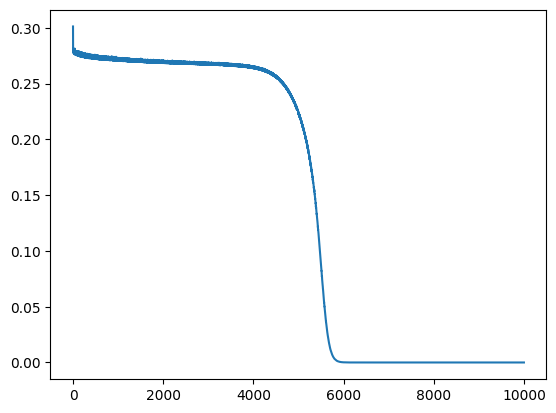

In [3]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np

loss_list = []
torch.manual_seed(42)

x = torch.tensor([[0,0],[0,1],[1,0],[1,1]],dtype=torch.float32)
y = torch.tensor([0,1,1,0],dtype=torch.float32)

class XORModel(nn.Module):
    def __init__(self):
        super(XORModel,self).__init__()
        self.linear1 = nn.Linear(2,2,bias = True)
        self.activation1 = nn.Sigmoid()
        self.linear2 = nn.Linear(2,1,bias = True)
    def forward(self,x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        return x

class MyDataset(Dataset):
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self,idx):
        return self.X[idx].to(device),self.Y[idx].to(device)

dataset = MyDataset(x,y)
batch_size = 1
train_data_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = XORModel().to(device)
print(model)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.03)

def train_one_epoch(epoch_index):
    totalloss = 0
    for i,data in enumerate(train_data_loader):
        inputs,labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs.flatten(),labels)
        loss.backward()
        optimizer.step()
        totalloss += loss.item()
    return totalloss/(len(train_data_loader)*batch_size)

EPOCHS = 10000
for epoch in range(1,EPOCHS+1):
    model.train(True)
    avg_loss = train_one_epoch(epoch)
    loss_list.append(avg_loss)
    if epoch%1000 == 0:
        print(f"Epoch {epoch}/{EPOCHS}, Loss = {avg_loss}")

total_params = 0
for name,param in model.named_parameters():
    params = param.numel()
    total_params += params
print(total_params)

input = torch.tensor([0.,1.]).to(device)
model.eval()
print("Input = ",input)
print("Output = ",model(input))
plt.plot(loss_list)

### DEEP FF NN

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transform
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
from torch.utils.data import Dataset,DataLoader

class DeepFFClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(784,100,bias=True),
                                 nn.ReLU(),
                                 nn.Linear(100,100,bias=True),
                                 nn.ReLU(),
                                 nn.Linear(100,10,bias=True),
                                )
    def forward(self,x):
        x = x.view(-1, 784)
        return self.net(x)

mnist_trainset = datasets.MNIST(root="./data",download = True,train=True,transform=ToTensor())
train_loader = DataLoader(mnist_trainset,batch_size=50,shuffle=True)
mnist_testset = datasets.MNIST(root="./data",download = True,train=False,transform=ToTensor())
test_loader = DataLoader(mnist_testset,batch_size=50,shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepFFClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

total_params = 0
for name,param in model.named_parameters():
    params = param.numel()
    total_params += params

for epoch in range(6):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print(f"Finished Training. Final loss = {loss.item()}, Total params = {total_params}")

mat = [[0 for _ in range(10)] for _ in range(10)]

correct,total = 0,0
for i,vdata in enumerate(test_loader):
    tinputs,tlabels = vdata[0].to(device), vdata[1].to(device)
    toutputs = model(tinputs)

    _,predicted = torch.max(toutputs,1)
    total += tlabels.size(0)
    correct += (predicted==tlabels).sum()

    for i in range(len(predicted)):
        mat[predicted[i].item()][tlabels[i].item()] += 1

print(f"Correct = {correct}, Total = {total}")
for i in range(10):
    print(mat[i])

[1,   100] loss: 2.283
[1,   200] loss: 2.235
[1,   300] loss: 2.149
[1,   400] loss: 2.012
[1,   500] loss: 1.789
[1,   600] loss: 1.523
[1,   700] loss: 1.232
[1,   800] loss: 1.030
[1,   900] loss: 0.861
[1,  1000] loss: 0.752
[1,  1100] loss: 0.670
[1,  1200] loss: 0.588
[2,   100] loss: 0.577
[2,   200] loss: 0.512
[2,   300] loss: 0.487
[2,   400] loss: 0.482
[2,   500] loss: 0.477
[2,   600] loss: 0.452
[2,   700] loss: 0.434
[2,   800] loss: 0.428
[2,   900] loss: 0.429
[2,  1000] loss: 0.407
[2,  1100] loss: 0.376
[2,  1200] loss: 0.404
[3,   100] loss: 0.380
[3,   200] loss: 0.376
[3,   300] loss: 0.375
[3,   400] loss: 0.364
[3,   500] loss: 0.359
[3,   600] loss: 0.360
[3,   700] loss: 0.341
[3,   800] loss: 0.346
[3,   900] loss: 0.360
[3,  1000] loss: 0.345
[3,  1100] loss: 0.341
[3,  1200] loss: 0.326
[4,   100] loss: 0.340
[4,   200] loss: 0.324
[4,   300] loss: 0.325
[4,   400] loss: 0.340
[4,   500] loss: 0.314
[4,   600] loss: 0.328
[4,   700] loss: 0.308
[4,   800] 

### LINEAR RESGRESSION

In [5]:
import torch
from torch.utils.data import Dataset,DataLoader

class MyDataset(Dataset):
    def __init__(self,X1,X2,Y):
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
    def __len__(self):
        return len(self.X1)
    def __getitem__(self,idx):
        return self.X1[idx],self.X2[idx],self.Y[idx]

x1 = torch.tensor([3,4,5,6,2])
x2 = torch.tensor([8,5,7,3,1])
y = torch.tensor([-3.5,3.5,2.5,11.5,5.7])
dataset = MyDataset(x1,x2,y)
data_loader = DataLoader(dataset,batch_size=2,shuffle=True)

for data in iter(data_loader):
    print(data)

class RegressionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = torch.nn.Parameter(torch.rand([1],requires_grad = True))
        self.w2 = torch.nn.Parameter(torch.rand([1],requires_grad = True))
        self.b = torch.nn.Parameter(torch.rand([1],requires_grad = True))
    def forward(self,x1,x2):
        return self.w1*x1 + self.w2*x2 + self.b

loss_fn = torch.nn.MSELoss()
model = RegressionModel()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001)

for epochs in range(100):
    loss = 0.0
    for i,data in enumerate(data_loader):
        x1,x2,labels = data
        optimizer.zero_grad()
        outputs = model(x1,x2)
        loss = loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
    loss += loss.item()

    if epochs%33==0:
        print("After {} epochs, The parameters are w={},b={}, and loss ={}".format(epochs, model.w1,model.w2,model.b,loss.item()))

    finalloss = loss/len(data_loader)*4

print(finalloss)

[tensor([3, 4]), tensor([8, 5]), tensor([-3.5000,  3.5000])]
[tensor([2, 6]), tensor([1, 3]), tensor([ 5.7000, 11.5000])]
[tensor([5]), tensor([7]), tensor([2.5000])]
After 0 epochs, The parameters are w=Parameter containing:
tensor([0.8728], requires_grad=True),b=Parameter containing:
tensor([0.3665], requires_grad=True), and loss =Parameter containing:
tensor([0.6845], requires_grad=True)
After 33 epochs, The parameters are w=Parameter containing:
tensor([1.5386], requires_grad=True),b=Parameter containing:
tensor([-0.7342], requires_grad=True), and loss =Parameter containing:
tensor([0.7649], requires_grad=True)
After 66 epochs, The parameters are w=Parameter containing:
tensor([2.0216], requires_grad=True),b=Parameter containing:
tensor([-1.1250], requires_grad=True), and loss =Parameter containing:
tensor([0.8641], requires_grad=True)
After 99 epochs, The parameters are w=Parameter containing:
tensor([2.2700], requires_grad=True),b=Parameter containing:
tensor([-1.3380], requires_